## NoteBook to Train and Visualize the U-Net Network

In [14]:
# Importing bunch of libraries
import os
import sys
import time
import random
import warnings
import glob

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from skimage.io import imread, imshow
from skimage.transform import resize

import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from keras import backend as K
#from keras.utils import multi_gpu_model
#replaced by tf.distribute.MirroredStrategy()

# Specify image dimensions
# Please note that the code may not function as expected for different image size
# (It will definitely not run for smaller images)
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed

2023-01-25 13:37:52.505821: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-25 13:37:54.341492: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/cescollino/Workspace/abd-skin-segmentation/venv/lib/python3.10/site-packages/cv2/../../lib64:
2023-01-25 13:37:54.341710: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/cescollino/Workspace/abd

In [4]:
import torch
print(torch.cuda.is_available())
print(torch.version.cuda)


True
11.7


### Function Definitions

In [5]:
## Function for computing the masks' pixel-to-pixel accuracy, takes as input 2D masks and 2D predictions
# (Label 1 corresponds to skin, and 0 to non-skin)
# TP - true positive: mask and prediction pixels refer to skin
# TN - true negative: mask and prediction pixels refer to non-skin
# FP - false positive: mask pixels refer to non-skin, prediction pixels refer to skin
# FN - false negative: mask pixels refer to skin, prediction pixels refer to non-skin

def acc_comp(msk, preds_test_t):
    
    mean_acc = np.zeros(1)
    mean_TP = np.zeros(1)
    mean_TN = np.zeros(1)
    mean_FP = np.zeros(1)
    mean_FN = np.zeros(1)
    
    for j in range(msk.shape[0]):
        act = msk[j]
        pr = preds_test_t[j].reshape(IMG_WIDTH, IMG_HEIGHT)
    
        c = act == pr 
        d = act & pr 
        e = act | pr 
        neg = act.sum()
        pos = (IMG_WIDTH*IMG_HEIGHT)-act.sum()
    
        TP = round(float(d.sum()),6)
        FP = round(float(pr.sum()-d.sum()),6)
        TN = round(float((IMG_WIDTH*IMG_HEIGHT)-e.sum()),6)
        FN = round(float(e.sum()-pr.sum()),6)
        acc = round(float(c.sum())/(IMG_WIDTH*IMG_HEIGHT),6)

        mean_TP = np.append([mean_TP],TP)
        mean_TN = np.append([mean_TN],TN)
        mean_acc = np.append([mean_acc],acc)
        mean_FP = np.append([mean_FP],FP)
        mean_FN = np.append([mean_FN],FN)
    
    mean_acc = mean_acc[1:]
    mean_TP = mean_TP[1:]
    mean_TN = mean_TN[1:]
    mean_FP = mean_FP[1:]
    mean_FN = mean_FN[1:]
    std = round(np.std(mean_acc),6)

## Average accuracy for all images    
#     avg = round(mean_acc.sum()/msk.shape[0],6) 
## Average number of true positive pixels (only meaningful if all images have the same shape)
#     overall_TP = round(mean_TP.sum()/msk.shape[0],6)
## Average number of true negative pixels (only meaningful if all images have the same shape)
#     overall_TN = round(mean_TN.sum()/msk.shape[0],6)
    
    return (mean_acc,std,mean_TP,mean_TN,mean_FP,mean_FN)

## Class for extracting time elapsed per training epoch

class TimingCallback(Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

cb = TimingCallback()
    
## Intersection-over-Union (IoU) metric, can be tracked instead of the accuracy during training

def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

### This is where the actual implementation of the algorithm starts. You should run everything in order
#### A) Get the training data (original images + masks). It is better that the images and masks have the same names. The only thing you need to be concerned with is the sorting of the images. They will be sorted by their names, so you want your original images and corresponding masks to have matching names.  This section adds the original images' path to TRAIN_PATH, and the masks' path to MASK_PATH. You don't have to worry about the naming if you are using our datasets from Google Drive.

#### You should replace the paths with the ones corresponding to your machine. Open a terminal, go to the All_Skin_Datasets directory, and type pwd. That would be the path to the datasets folder. 

In [6]:
# Dataset 1: HGR
import pathlib
ROOT = str(pathlib.Path(os.path.abspath(os.curdir)).parent)
print(ROOT)
TP1 = ROOT + '/All_Skin_Datasets/Dataset1_HGR/original_images/'
TRAIN_PATH1 = [TP1] #['/home/anirudh/skin_dataset/All_Skin_Datasets/Dataset1_HGR/original_images/']
MP1 = ROOT + '/All_Skin_Datasets/Dataset1_HGR/skin_masks/'
MASK_PATH1 = [MP1] #['/home/anirudh/skin_dataset/All_Skin_Datasets/Dataset1_HGR/skin_masks/']
train_ids1 = next(os.walk(TRAIN_PATH1[0]))[2]
mask_ids1 = next(os.walk(MASK_PATH1[0]))[2]
train_ids1.sort()
mask_ids1.sort()
TRAIN_PATH1 = TRAIN_PATH1*len(train_ids1)
MASK_PATH1 = MASK_PATH1*len(train_ids1)

# Dataset 2: TDSD
TP5 = ROOT + '/All_Skin_Datasets/Dataset2_TDSD/original_images/'
TRAIN_PATH5 = [TP5] #['/home/anirudh/skin_dataset/All_Skin_Datasets/Dataset2_TDSD/original_images/']
MP5 =  ROOT + '/All_Skin_Datasets/Dataset2_TDSD/skin_masks/'
MASK_PATH5 = [MP5] #['/home/anirudh/skin_dataset/All_Skin_Datasets/Dataset2_TDSD/skin_masks/']
train_ids5 = next(os.walk(TRAIN_PATH5[0]))[2]
mask_ids5 = next(os.walk(MASK_PATH5[0]))[2]
train_ids5.sort()
mask_ids5.sort()
TRAIN_PATH5 = TRAIN_PATH5*len(train_ids5)
MASK_PATH5 = MASK_PATH5*len(train_ids5)

# Dataset 3: Schmugge
TP6 = ROOT + '/All_Skin_Datasets/Dataset3_Schmugge/original_images/'
TRAIN_PATH6 = [TP6]#['/home/anirudh/skin_dataset/All_Skin_Datasets/Dataset3_Schmugge/original_images/']
MP6 = ROOT + '/All_Skin_Datasets/Dataset3_Schmugge/skin_masks/'
MASK_PATH6 = [MP6] # ['/home/anirudh/skin_dataset/All_Skin_Datasets/Dataset3_Schmugge/skin_masks/']
train_ids6 = next(os.walk(TRAIN_PATH6[0]))[2]
mask_ids6 = next(os.walk(MASK_PATH6[0]))[2]
train_ids6.sort()
mask_ids6.sort()
TRAIN_PATH6 = TRAIN_PATH6*len(train_ids6)
MASK_PATH6 = MASK_PATH6*len(train_ids6)

# Dataset 4: Pratheepan
TP2 = ROOT + '/All_Skin_Datasets/Dataset4_Pratheepan/original_images/'
TRAIN_PATH2 = [TP2]#['/home/anirudh/skin_dataset/All_Skin_Datasets/Dataset4_Pratheepan/original_images/']
MP2 = ROOT + '/All_Skin_Datasets/Dataset4_Pratheepan/skin_masks/'
MASK_PATH2 = [TP2]#['/home/anirudh/skin_dataset/All_Skin_Datasets/Dataset4_Pratheepan/skin_masks/']
train_ids2 = next(os.walk(TRAIN_PATH2[0]))[2]
mask_ids2 = next(os.walk(MASK_PATH2[0]))[2]
train_ids2.sort()
mask_ids2.sort()
TRAIN_PATH2 = TRAIN_PATH2*len(train_ids2)
MASK_PATH2 = MASK_PATH2*len(train_ids2)

# Dataset 5: VDM
TP3 = ROOT + '/All_Skin_Datasets/Dataset5_VDM/original_images/'
TRAIN_PATH3 = [TP3] #['/home/anirudh/skin_dataset/All_Skin_Datasets/Dataset5_VDM/original_images/']
MP3 = ROOT + '/All_Skin_Datasets/Dataset5_VDM/skin_masks/'
MASK_PATH3 = [MP3] #['/home/anirudh/skin_dataset/All_Skin_Datasets/Dataset5_VDM/skin_masks/']
train_id3 = next(os.walk(TRAIN_PATH3[0]))[2]
mask_id3 = next(os.walk(MASK_PATH3[0]))[2]
train_id3.sort()
mask_id3.sort()
train_ids3 = train_id3[1:]
mask_ids3 = mask_id3[1:]
TRAIN_PATH3 = TRAIN_PATH3*len(train_ids3)
MASK_PATH3 = MASK_PATH3*len(train_ids3)

# Dataset 6: SFA
TP4 = ROOT + '/All_Skin_Datasets/Dataset6_SFA/original_images/'
TRAIN_PATH4 = [TP4] #['/home/anirudh/skin_dataset/All_Skin_Datasets/Dataset6_SFA/original_images/']
MP4 = ROOT + '/All_Skin_Datasets/Dataset6_SFA/skin_masks/'
MASK_PATH4 = [MP4] #['/home/anirudh/skin_dataset/All_Skin_Datasets/Dataset6_SFA/skin_masks/']
train_ids4 = next(os.walk(TRAIN_PATH4[0]))[2]
mask_ids4 = next(os.walk(MASK_PATH4[0]))[2]
train_ids4.sort()
mask_ids4.sort()
TRAIN_PATH4 = TRAIN_PATH4*len(train_ids4)
MASK_PATH4 = MASK_PATH4*len(train_ids4)

# Dataset 7: FSD
TP7 = ROOT + '/All_Skin_Datasets/Dataset7_FSD/original_images/'
TRAIN_PATH7 = [TP7] #['/home/anirudh/skin_dataset/All_Skin_Datasets/Dataset7_FSD/original_images/']
MP7 = ROOT + '/All_Skin_Datasets/Dataset7_FSD/skin_masks/'
MASK_PATH7 = [MP7] #['/home/anirudh/skin_dataset/All_Skin_Datasets/Dataset7_FSD/skin_masks/']
train_ids7 = next(os.walk(TRAIN_PATH7[0]))[2]
mask_ids7 = next(os.walk(MASK_PATH7[0]))[2]
train_ids7.sort()
mask_ids7.sort()
TRAIN_PATH7 = TRAIN_PATH7*len(train_ids7)
MASK_PATH7 = MASK_PATH7*len(train_ids7)

# # Dataset 8: ABDOMEN
TP8 = ROOT + '/All_Skin_Datasets/Dataset8_Abdomen/train/original_images/'
TRAIN_PATH8 = [TP8] #['/home/anirudh/skin_dataset/All_Skin_Datasets/Dataset8_Abdomen/train/original_images/']
MP8 = ROOT + '/All_Skin_Datasets/Dataset8_Abdomen/train/skin_masks/'
MASK_PATH8 = [MP8] #['/home/anirudh/skin_dataset/All_Skin_Datasets/Dataset8_Abdomen/train/skin_masks/']
train_ids8 = next(os.walk(TRAIN_PATH8[0]))[2]
mask_ids8 = next(os.walk(MASK_PATH8[0]))[2]
train_ids8.sort()
mask_ids8.sort()

TRAIN_PATH8 = TRAIN_PATH8*len(train_ids8)
MASK_PATH8 = MASK_PATH8*len(train_ids8)

# Combining all datasets together
TRAIN_PATH = np.concatenate((TRAIN_PATH1,TRAIN_PATH2,TRAIN_PATH3,TRAIN_PATH4,TRAIN_PATH5, TRAIN_PATH6,TRAIN_PATH7,TRAIN_PATH8))
MASK_PATH = np.concatenate((MASK_PATH1,MASK_PATH2,MASK_PATH3,MASK_PATH4,MASK_PATH5,MASK_PATH6,MASK_PATH7,MASK_PATH8))
train_ids = np.concatenate((train_ids1,train_ids2,train_ids3,train_ids4,train_ids5,train_ids6,train_ids7,train_ids8))
mask_ids = np.concatenate((mask_ids1,mask_ids2,mask_ids3,mask_ids4,mask_ids5,mask_ids6,mask_ids7,mask_ids8))

print(TRAIN_PATH)
print(MASK_PATH)
print(train_ids)
print(mask_ids)

/home/cescollino/Workspace/abd-skin-segmentation
['/home/cescollino/Workspace/abd-skin-segmentation/All_Skin_Datasets/Dataset1_HGR/original_images/'
 '/home/cescollino/Workspace/abd-skin-segmentation/All_Skin_Datasets/Dataset1_HGR/original_images/'
 '/home/cescollino/Workspace/abd-skin-segmentation/All_Skin_Datasets/Dataset1_HGR/original_images/'
 ...
 '/home/cescollino/Workspace/abd-skin-segmentation/All_Skin_Datasets/Dataset8_Abdomen/train/original_images/'
 '/home/cescollino/Workspace/abd-skin-segmentation/All_Skin_Datasets/Dataset8_Abdomen/train/original_images/'
 '/home/cescollino/Workspace/abd-skin-segmentation/All_Skin_Datasets/Dataset8_Abdomen/train/original_images/']
['/home/cescollino/Workspace/abd-skin-segmentation/All_Skin_Datasets/Dataset1_HGR/skin_masks/'
 '/home/cescollino/Workspace/abd-skin-segmentation/All_Skin_Datasets/Dataset1_HGR/skin_masks/'
 '/home/cescollino/Workspace/abd-skin-segmentation/All_Skin_Datasets/Dataset1_HGR/skin_masks/'
 ...
 '/home/cescollino/Worksp

#### B) Shuffle the data and resize to the dimensions specified in the first block

In [7]:
# This creates two array of zeros (for the ground truth and mask data) to store the images in them
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1))
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
g = list(range(0,len(train_ids)))
np.random.shuffle(g)

# Creates string arrays to store the path for every training image
strs_original = ["" for x in range(len(train_ids))]
strs_mask = ["" for x in range(len(train_ids))]
pathmsk = MASK_PATH[0] + mask_ids[0]
# Store images path in the corresponding arrays (one array for masks, one for the original ones)
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    strs_mask[n] = MASK_PATH[n] + mask_ids[n]
    strs_original[n] = TRAIN_PATH[n] + train_ids[n]

# Read images from their paths and store them in arrays
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = strs_original[g[n]]
    img = imread(path)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    
    path = strs_mask[g[n]]
    img = imread(path)
    if img.ndim == 3:
        img = img[:,:,1]
    img = np.expand_dims(resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
    if (np.unique(img).size) > 2:
        # Important, this is needed to convert masks into binary numbers, as some pixels are between 0 and 255
        img = img > 30
    else:
        img = img > 0
    Y_train[n] = img      

Getting and resizing train images and masks ... 


/tmp/ipykernel_4118/3290116957.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):


  0%|          | 0/8879 [00:00<?, ?it/s]

/tmp/ipykernel_4118/3290116957.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):


  0%|          | 0/8879 [00:00<?, ?it/s]

#### Save the data to load easily next time. The saving and loading might actually take more time than just running parts A and B. Your call!

In [8]:
## Saving
# np.save("X_data",X_train)
# np.save("Y_data",Y_train)

## Loading
# X_train = np.load('./X_data.npy')
# Y_train = np.load('./Y_data.npy')

#### C) Double check your work! This will output the images and the corresponding masks. Very useful to ensure that the data has been correctly matched. If the images don't match chances are you've messed up the naming.

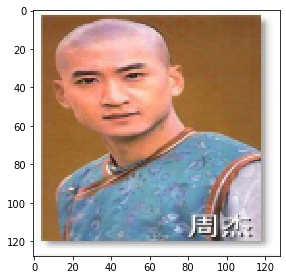

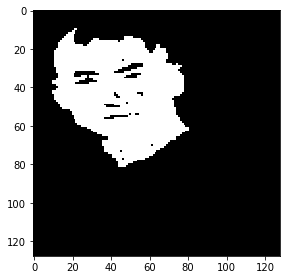

In [9]:
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

#### D) Construct the U-Net model, based on the "U-net:Convolutional networks for biomedical image segmentation" paper by Ronneberger et al.

In [10]:
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x/255) (inputs)

# Convolution layer
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (s)
# Dropout layer
c1 = Dropout(0.1) (c1)
# Another convolution layer
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
# Maxpooling layer
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)

# Deconvolution layer
u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
#model = tf.keras.utils.multi_gpu_model(model, gpus=4)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

2023-01-18 20:56:29.683097: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-18 20:56:29.684105: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-18 20:56:29.684335: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-18 20:56:29.684460: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
#### E) Fit the model to the training data

In [11]:
import tensorflow as tf
import torch
print('---------TENSORFLOW-----------------')
print(tf.__version__)
print("Available: ", tf.config.list_physical_devices())
print('---------TORCH-----------------')
print('is cuda available?',torch.cuda.is_available())
print('how many gpus?',torch.cuda.device_count())
print('what card?',torch.cuda.get_device_name(0))

def force_cudnn_initialization():
    s = 32
    dev = torch.device('cuda')
    torch.nn.functional.conv2d(torch.zeros(s, s, s, s, device=dev), torch.zeros(s, s, s, s, device=dev))
force_cudnn_initialization()

---------TENSORFLOW-----------------
2.11.0
Available:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
---------TORCH-----------------
is cuda available? True
how many gpus? 1
what card? NVIDIA GeForce GTX 1070


In [12]:
earlystopper = EarlyStopping(patience=30, verbose=1)
checkpointer = ModelCheckpoint('your_model_name.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.20, batch_size=64, epochs=50, shuffle=True, 
                    callbacks=[earlystopper, checkpointer, cb])

Epoch 1/50


2023-01-18 20:57:15.008623: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-01-18 20:57:15.526356: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8500
2023-01-18 20:57:16.559653: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x55ccffa80450 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-01-18 20:57:16.559689: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce GTX 1070, Compute Capability 6.1
2023-01-18 20:57:16.592532: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-01-18 20:57:16.907753: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Comp

111/111 [==============================] - ETA: 0s - loss: 0.4590 - acc: 0.7690
Epoch 1: val_loss improved from inf to 0.36033, saving model to your_model_name.h5
111/111 [==============================] - 32s 212ms/step - loss: 0.4590 - acc: 0.7690 - val_loss: 0.3603 - val_acc: 0.8678
Epoch 2/50
111/111 [==============================] - ETA: 0s - loss: 0.3292 - acc: 0.8641
Epoch 2: val_loss improved from 0.36033 to 0.27601, saving model to your_model_name.h5
111/111 [==============================] - 21s 191ms/step - loss: 0.3292 - acc: 0.8641 - val_loss: 0.2760 - val_acc: 0.8905
Epoch 3/50
111/111 [==============================] - ETA: 0s - loss: 0.2672 - acc: 0.8958
Epoch 3: val_loss improved from 0.27601 to 0.22868, saving model to your_model_name.h5
111/111 [==============================] - 21s 192ms/step - loss: 0.2672 - acc: 0.8958 - val_loss: 0.2287 - val_acc: 0.9103
Epoch 4/50
111/111 [==============================] - ETA: 0s - loss: 0.2353 - acc: 0.9096
Epoch 4: val_loss 

#### F) Output training results and plots

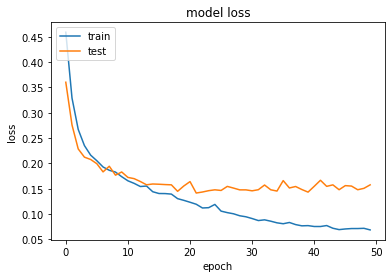

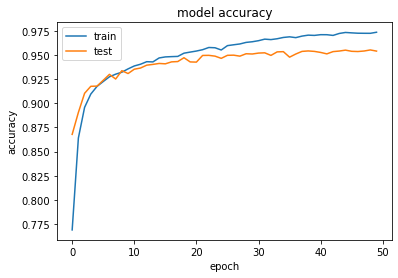

UNET ARCHITECTURE
-------------------------------------------------------------
Total num of training images: 8879
Max num of epochs: 50
Optimizer: ADAM
Batch size: 64
Loss function: Binary Cross-Entropy
Validation data percentage: 10
Early stoppping: Yes
-------------------------------------------------------------
#    Time sec      Tr_acc     Tr_loss      Vl_acc     Vl_loss
-------------------------------------------------------------
0   32.291500   0.769000    0.459000    0.867800    0.360327
1   21.187900   0.864100    0.329200    0.890500    0.276012
2   21.303200   0.895800    0.267200    0.910300    0.228685
3   21.344900   0.909600    0.235300    0.917600    0.212467
4   21.603000   0.917500    0.216400    0.917800    0.207883
5   21.709500   0.922500    0.205400    0.923800    0.199485
6   21.800500   0.927400    0.193000    0.929900    0.183378
7   21.649400   0.930100    0.186500    0.925100    0.194508
8   21.618300   0.932200    0.183000    0.933700    0.176905
9   21.43

In [15]:
# Summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Summarize history for accuracy (or mean iou, depending on what you use)
plt.plot(results.history['acc'])
plt.plot(results.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Results and Plots
# model.summary()
print("UNET ARCHITECTURE")
print ("-------------------------------------------------------------")
print("Total num of training images: %d" % len(train_ids))
print("Max num of epochs: %d" % 50)
print("Optimizer: %s" % 'ADAM')
print("Batch size: %d" % 64)
print("Loss function: %s" % 'Binary Cross-Entropy')
print("Validation data percentage: %d" % 10)
print("Early stoppping: %s" % 'Yes')

a = results.history["acc"]
b = results.history["loss"]
c = results.history["val_acc"]
d = results.history["val_loss"]
e = cb.times
print ("-------------------------------------------------------------")
header = "#"+"    "+"Time sec"+"      "+"Tr_acc"+"     "+"Tr_loss"+"      "+"Vl_acc"+"     "+"Vl_loss"
print(header)
print ("-------------------------------------------------------------")
for l in range(50):#epochs
    str = "%d\t\t%f\t\t%f\t\t%f\t\t%f\t\t%f" % (l, round(e[l],4),round(a[l],4),round(b[l],4),round(c[l],4),d[l])
    print (str.expandtabs(2))
print ("-------------------------------------------------------------")

#### G) Test against training and validation samples

In [16]:
# Load your trained model
model = load_model('your_model_name.h5', custom_objects={'mean_iou': mean_iou})
# Pedict masks for the training data
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.8)], verbose=1)
# Predict masks for the validation data
preds_val = model.predict(X_train[int(X_train.shape[0]*0.8):], verbose=1)

# Threshold out the predictions, turn them into a type that can be shown as an image
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

56/56 [==============================] - 1s 18ms/step



CA #### H) See predicted masks for training samples

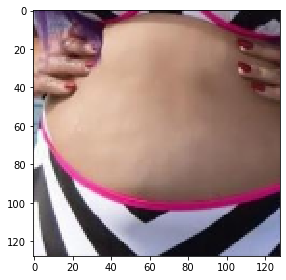

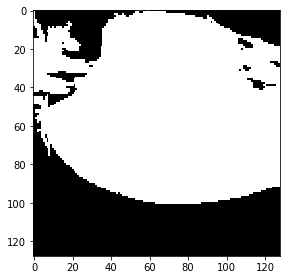

In [ ]:
# Sanity check on random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

#### I) See predicted masks for validation data

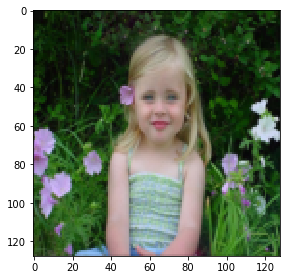

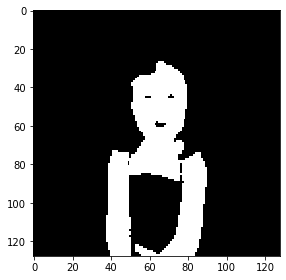

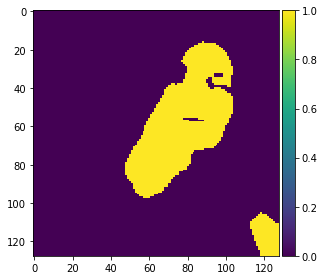

In [18]:
# Sanity check on random validation samples
# Plot the original image
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.7):][ix])
plt.show()

# Plot the actual mask
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.7):][ix]))
plt.show()

# Plot the predicted mask
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

#### J) Load model, testing data and check against trained network (if masks exist)

In [19]:
# Load the model for testing, same logic follows for extracting the testing data
model = load_model('your_model_name.h5', custom_objects={'mean_iou': mean_iou})
ABD_PATH = 'path_to_img_data'
MSK_PATH = 'path_to_mask_data'

abd_ids = next(os.walk(ABD_PATH))[2]
msk_ids = next(os.walk(MSK_PATH))[2]
abd_ids.sort()
msk_ids.sort()

abd = np.zeros((len(abd_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
msk = np.zeros((len(msk_ids), IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)

sys.stdout.flush()
for n, id_ in tqdm(enumerate(abd_ids), total=len(abd_ids)):
    path = ABD_PATH + id_
    img = imread(path)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    abd[n] = img
    
for n, id_ in tqdm(enumerate(msk_ids), total=len(msk_ids)):
    path = MSK_PATH + id_
    img = imread(path)
    
    if img.ndim == 3:
        img = img[:,:,1]
        
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True)
    if (np.unique(img).size) > 2:
        img = img > 30           # Important, Needed to make labels 0's and 1's only   
    else:   
        img = img > 0
    img = img.astype(np.uint8)
    msk[n] = img
    
# Actual Predictions
preds_test = model.predict(abd[:int(abd.shape[0])], verbose=1)

# Threshold predictions
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Overall accuracy on abdomen pictures
answer = acc_comp(msk, preds_test_t);

## Save TP, TN, FP and FN results in a .npy file if you want to analyze further the results
# a = np.reshape(answer[2],(100,1))
# b = np.reshape(answer[3],(100,1))
# c = np.reshape(answer[4],(100,1))
# d = np.reshape(answer[5],(100,1))
# g = np.concatenate([a,b,c,d],axis = 1)
# np.save('your_file_name.npy',g)

StopIteration: 

#### K) Visualize results

In [20]:
# This will output ALL the training results, so be careful
for j in range(len(abd_ids)):
    print(j)
    plt.show()
    imshow(abd[j])
    plt.show()
    imshow(np.squeeze(preds_test_t[j]*255))
    plt.show()
    imshow(np.squeeze(msk[j]))

NameError: name 'abd_ids' is not defined

#### J) Load model, testing data and check against trained network (if masks do NOT exist)

In [ ]:
model = load_model('model_name.h5', custom_objects={'mean_iou': mean_iou})
ABD_PATH = 'path_to_img_data'

abd_ids = next(os.walk(ABD_PATH))[2]
abd_ids.sort()

abd = np.zeros((len(abd_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

sys.stdout.flush()
for n, id_ in tqdm(enumerate(abd_ids), total=len(abd_ids)):
    path = ABD_PATH + id_
    img = imread(path)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    abd[n] = img
    
# Actual Predictions
preds_test = model.predict(abd[:int(abd.shape[0])], verbose=1)

# Threshold predictions
preds_test_t = (preds_test > 0.5).astype(np.uint8)

#### K) Visualize results

In [ ]:
for j in range(len(abd_ids)):
    print(j)
    plt.show()
    imshow(abd[j])
    plt.show()
    imshow(np.squeeze(preds_test_t[j]*255))
    plt.show()

#### L) Calculate Metrics for Abdomen Dataset 

In [ ]:
## Load Data
ABD_PATH = ['/Users/lydiazoghbi/Desktop/All_Skin_Datasets/Dataset8_Abdomen/test/original_images/']
MSK_PATH = ['/Users/lydiazoghbi/Desktop/All_Skin_Datasets/Dataset8_Abdomen/test/skin_masks/']
abd_ids = next(os.walk(ABD_PATH))[2]
msk_ids = next(os.walk(MSK_PATH))[2]
abd_ids.sort()
msk_ids.sort()

## Calculating Predictions
abd = np.zeros((len(abd_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
msk = np.zeros((len(msk_ids), IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)

sys.stdout.flush()
for n, id_ in tqdm(enumerate(abd_ids), total=len(abd_ids)):
    path = ABD_PATH + id_
    img = imread(path)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    abd[n] = img
    
for n, id_ in tqdm(enumerate(msk_ids), total=len(msk_ids)):
    path = MSK_PATH + id_
    img = imread(path)
    
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True)
    if (np.unique(img).size) >= 2:
        img = img > 30           # Important, Needed to make labels 0's and 1's only   
    else:   
        img = img > 0
    img = img.astype(np.uint8)
    msk[n] = img
    
# Actual Predictions
preds_test = model.predict(abd[:int(abd.shape[0])], verbose=1)

# Threshold predictions
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Calculating Metrics
mean_acc = acc_comp(msk, preds_test_t)avg = np.mean(mean_acc)
std = np.std(mean_acc)
print("average " + str(avg) )
print("STD " + str(std) )

# skin segmentation on public images

In [16]:
# Importing bunch of libraries
import os
import sys
import time
import random
import warnings
import glob

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from skimage.io import imread, imshow
from skimage.transform import resize

import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from keras import backend as K
#from keras.utils import multi_gpu_model
#replaced by tf.distribute.MirroredStrategy()

# Specify image dimensions
# Please note that the code may not function as expected for different image size
# (It will definitely not run for smaller images)
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed

In [24]:
# Dataset 9 : Pediatrics - SyRIP

realbabies = glob.glob("/home/cescollino/Workspace/abd-skin-segmentation/coe.northeastern.edu/Research/AClab/SyRIP/images/train_infant/train0*.jpg")
realbabies = realbabies[:-400]
X_BB = np.zeros((len(realbabies), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
print("shape of testing data is :",np.shape(X_BB))
print('Getting and resizing train images and masks ... ')
# print(realbabies)
# Read images from their paths and store them in arrays
for n, id_ in tqdm(enumerate(realbabies), total=len(realbabies)):
    img = imread(id_)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_BB[n] = img




shape of testing data is : (500, 128, 128, 3)
Getting and resizing train images and masks ... 


/tmp/ipykernel_177581/494883145.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n, id_ in tqdm(enumerate(realbabies), total=len(realbabies)):


  0%|          | 0/500 [00:00<?, ?it/s]

In [25]:
## Intersection-over-Union (IoU) metric, can be tracked instead of the accuracy during training

def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [26]:
model = load_model('your_model_name.h5', custom_objects={'mean_iou': mean_iou})

2023-01-25 13:44:09.328505: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2023-01-25 13:44:09.328530: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: cescollino-MS-7998
2023-01-25 13:44:09.328535: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: cescollino-MS-7998
2023-01-25 13:44:09.328607: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 510.108.3
2023-01-25 13:44:09.328624: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 510.108.3
2023-01-25 13:44:09.328628: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 510.108.3
2023-01-25 13:44:09.329259: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI 

In [32]:
preds_BB = model.predict(X_BB[:X_BB.shape[0]], verbose=1)

16/16 [==============================] - 4s 225ms/step


424 out of 500


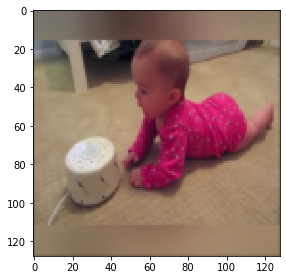

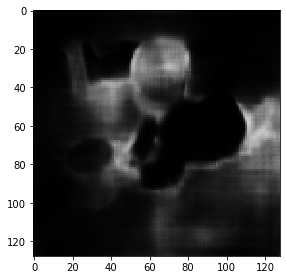

In [50]:
ix = random.randint(0, np.shape(X_BB)[0])
print(ix,"out of",np.shape(X_BB)[0] )
imshow(X_BB[ix])
plt.show()

imshow(preds_BB[ix])
plt.show()
# SPATH = 
# # Pedict masks for the training data
# preds_train = model.predict(X_train[:int(X_train.shape[0]*0.8)], verbose=1)

## medical images (google)